# Compute Mutual Information on MNIST Dataset + PSF Combinations, 9/25/2023

In [1]:
import numpy as np
from leyla_fns import *
import sys
sys.path.insert(0, '/home/lkabuli_waller/workspace/EncodingInformation/')
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
print(os.environ.get('PYTHONPATH'))


2023-09-25 13:57:15.648891: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 13:57:15.691427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 13:57:16.639457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


“:/home/lkabuli_waller/workspace/BSCCM:/home/lkabuli_waller/workspace/microscoBayes”


In [17]:
import matplotlib.pyplot as plt

### Load PSFs and MNIST Dataset
Dataset gets converted to units of photons, arbitrarily at 1000 photons for now

In [2]:
diffuser_psf = load_diffuser_psf()
phlat_psf = load_phlat_psf()
psf_4_psf = load_4_psf()
rml_psf = load_rml_psf()

In [3]:
#load mnist data
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
data = data.astype(np.float32)
for i in range(data.shape[0]):
    data[i] /= np.max(data[i])
    data[i] *= 1000 # convert to photons with arbitrary maximum value of 1000 photons
labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 

# set seed value for reproducibility and tile data using full mnist dataset
seed_value = 1
random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)

In [4]:
# make 5 imaging modality datas using the loaded psfs
uc_data = random_data[:, 14:-13, 14:-13]
psf_4_data = convolved_dataset(psf_4_psf, random_data)
diffuser_data = convolved_dataset(diffuser_psf, random_data)
phlat_data = convolved_dataset(phlat_psf, random_data)
rml_data = convolved_dataset(rml_psf, random_data)

100%|██████████| 70000/70000 [00:30<00:00, 2282.61it/s]


In [5]:
# get rid of super tiny negative values in psf_4 (and other datasets just to be safe)
if np.any(uc_data < 0):
    print('UC Data has negatives')
    uc_data[uc_data < 0] = 0
if np.any(diffuser_data < 0):
    print('Diffuser Data has negatives')
    diffuser_data[diffuser_data < 0] = 0
if np.any(phlat_data < 0):
    print('Phlat Data has negatives')
    phlat_data[phlat_data < 0] = 0
if np.any(rml_data < 0):
    print('RML Data has negatives')
    rml_data[rml_data < 0] = 0
if np.any(psf_4_data < 0):
    print('PSF_4 Data has negatives')
    psf_4_data[psf_4_data < 0] = 0

PSF_4 Data has negatives


### Add noise to each set of images, synthetic shot noise based on the amount of noise fundamentally in the system

In [6]:
from image_utils import add_shot_noise as add_shot_noise_new

In [7]:
uc_data_shot = add_shot_noise_new(uc_data)
psf_4_data_shot = add_shot_noise_new(psf_4_data)
diffuser_data_shot = add_shot_noise_new(diffuser_data)
phlat_data_shot = add_shot_noise_new(phlat_data)
rml_data_shot = add_shot_noise_new(rml_data)

### Extract patches from the stack of images, make noisefree and noisy patches
Using patch size of 28 and 10,000 patches gives super consistent results. 

It is valuable to test the same behavior using a smaller patch size, as well as going up to 60,000 or more patches (the true size of the MNIST dataset).

In [8]:
from image_utils import extract_patches
# this function extracts patches of a given patch size from the input stack, you can specify the seed and the number of patches

In [9]:
patch_size = 28
num_patches = 10000

In [10]:
uc_data_patch = extract_patches(uc_data, patch_size=patch_size, num_patches=num_patches, seed=1)
psf_4_data_patch = extract_patches(psf_4_data, patch_size=patch_size, num_patches=num_patches, seed=1)
diffuser_data_patch = extract_patches(diffuser_data, patch_size=patch_size, num_patches=num_patches, seed=1)
phlat_data_patch = extract_patches(phlat_data, patch_size=patch_size, num_patches=num_patches, seed=1)
rml_data_patch = extract_patches(rml_data, patch_size=patch_size, num_patches=num_patches, seed=1)

100%|██████████| 10000/10000 [00:00<00:00, 572351.19it/s]


100%|██████████| 10000/10000 [00:00<00:00, 760540.35it/s]


In [11]:
uc_data_shot_patch = extract_patches(uc_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
psf_4_data_shot_patch = extract_patches(psf_4_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
diffuser_data_shot_patch = extract_patches(diffuser_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
phlat_data_shot_patch = extract_patches(phlat_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)
rml_data_shot_patch = extract_patches(rml_data_shot, patch_size=patch_size, num_patches=num_patches, seed=1)

100%|██████████| 10000/10000 [00:13<00:00, 715.49it/s]


### Estimate mutual information from the noisy image set combo
Tweak patch size, number of patches, and cutoff until something shows up good

In [12]:
from information_estimation import estimate_mutual_information 
# inputs of noisy images, optional clean images (use these since I have them), flag of stationary model (set to True since my patches are a stationary model)
# cutoff percentile which needs to be tweaked. the more data there is, the lower this value can be and the less errors
# show_eigenvalue_plot

#### Measure MI on the clean image patches directly, and put clean_images as the same clean image patches
This gives some weird results, even when cutoff is increased significantly

In [13]:
cutoff = 40

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Matrix not positive definite. Adding 19.642230987548828 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Matrix not positive definite. Adding 1.0399584770202637 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Matrix not positive definite. Adding 0.5536893606185913 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Matrix not positive definite. Adding 68.48555755615234 to eigenvalues


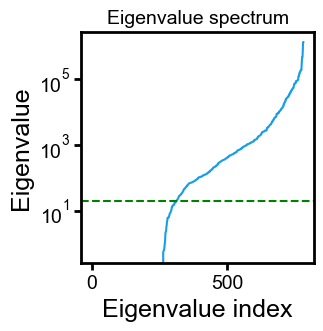

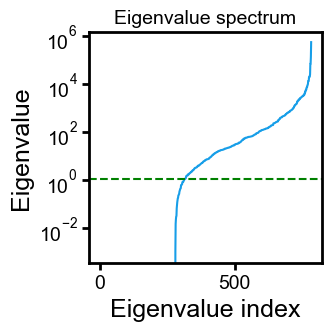

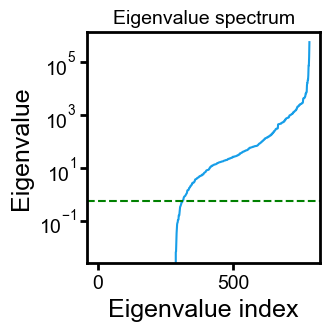

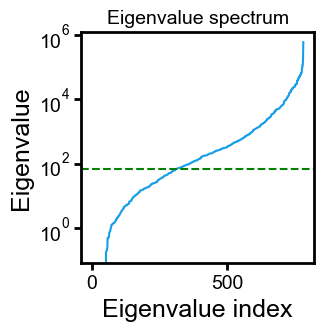

In [14]:
uc_mi = estimate_mutual_information(uc_data_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi = estimate_mutual_information(psf_4_data_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi = estimate_mutual_information(diffuser_data_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi = estimate_mutual_information(phlat_data_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi = estimate_mutual_information(rml_data_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)

7.440156 1.2615714 0.73946214 -1.622943 -1.8590757


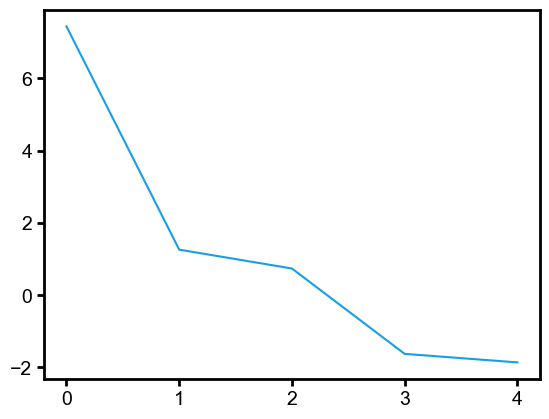

In [18]:
plt.plot([uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi])
print(uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)

#### Measure MI on the clean patches and don't have a reference clean_images set
This gives essentially the same (bad) results as above, measuring the MI of the noise-free set doesn't seem to be reasonable.

In [19]:
cutoff=40

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Matrix not positive definite. Adding 19.642230987548828 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Matrix not positive definite. Adding 1.0399584770202637 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Matrix not positive definite. Adding 0.5536893606185913 to eigenvalues


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Matrix not positive definite. Adding 68.48555755615234 to eigenvalues


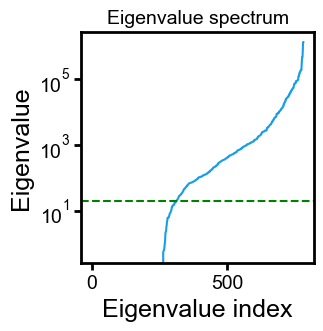

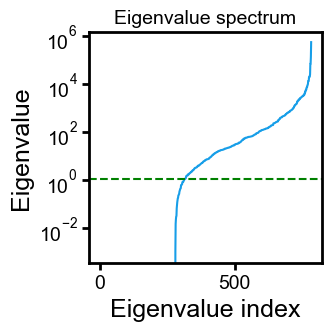

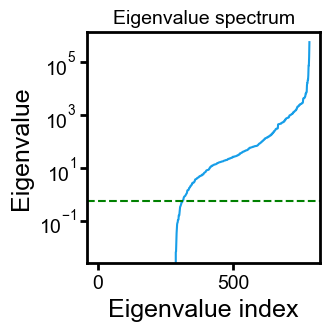

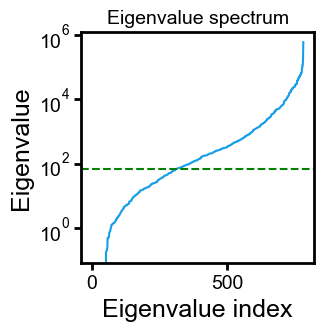

In [20]:
uc_mi = estimate_mutual_information(uc_data_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi = estimate_mutual_information(psf_4_data_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi = estimate_mutual_information(diffuser_data_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi = estimate_mutual_information(phlat_data_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi = estimate_mutual_information(rml_data_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)

7.440156 1.2615714 0.73946214 -1.622943 -1.8590757


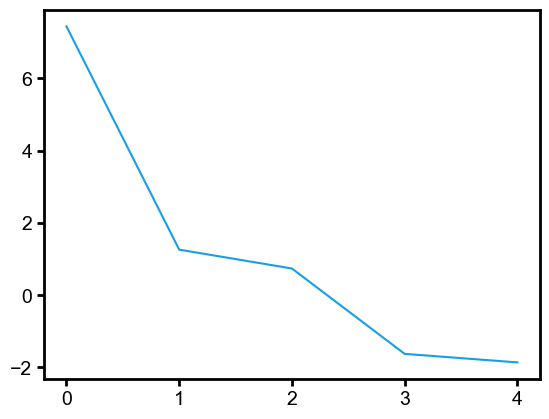

In [21]:
plt.plot([uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi])
print(uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)

#### Try using patches for the clean_images set - this works great
As low as cutoff = 5 seems to be just fine. This is with 10,000 data images
Shot noise patches are the main measurement, and clean images are the data patches

In [29]:
cutoff = 5

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

7.4538255 1.9526734 1.0960647 0.42523298 0.40776798


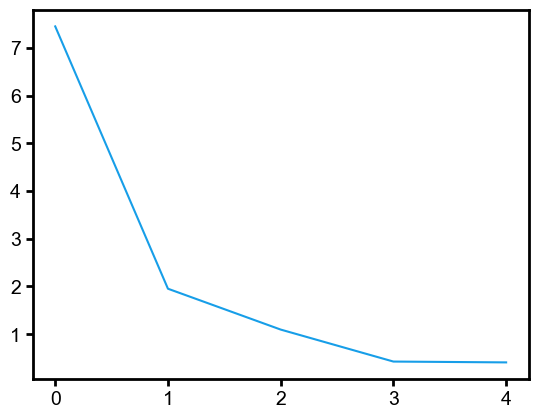

In [30]:
uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images=uc_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data_patch, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)

plt.plot([uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi])
print(uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)

#### Use the shot noise patches as is, and don't have a clean_image reference
This works great as well, it is super consistent with the true results from above with the patches for clean_images

In [24]:
cutoff = 5

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

7.4542236 1.8395828 1.1000056 0.42832616 0.4108589


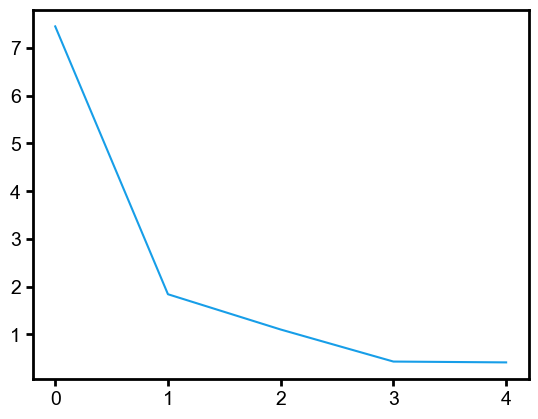

In [31]:
uc_mi_nc = estimate_mutual_information(uc_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi_nc = estimate_mutual_information(psf_4_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi_nc = estimate_mutual_information(diffuser_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi_nc = estimate_mutual_information(phlat_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi_nc = estimate_mutual_information(rml_data_shot_patch, clean_images=None, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
plt.plot([uc_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc])
print(uc_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc)

#### Compare the clean_image vs no clean_image outputs

In [36]:
print(uc_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc)
print(uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)
print(uc_mi_nc - uc_mi, psf_4_mi_nc - psf_4_mi, rml_mi_nc - rml_mi, diffuser_mi_nc - diffuser_mi, phlat_mi_nc - phlat_mi)

7.4542236 1.8395828 1.1000056 0.42832616 0.4108589
7.4538255 1.9526734 1.0960647 0.42523298 0.40776798
0.00039815903 -0.113090634 0.00394094 0.003093183 0.003090918


Text(0.5, 1.0, 'Mutual Information across Imaging Encoders')

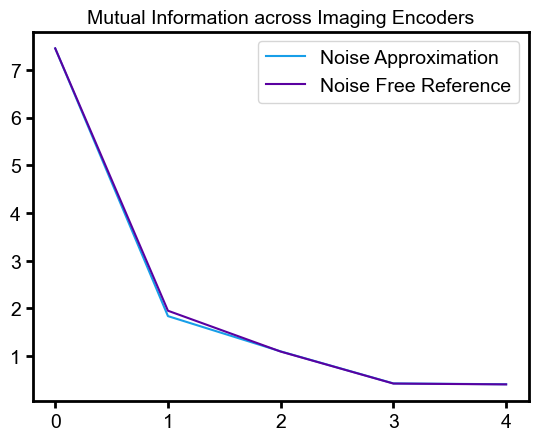

In [37]:
plt.plot([uc_mi_nc, psf_4_mi_nc, rml_mi_nc, diffuser_mi_nc, phlat_mi_nc], label='Noise Approximation')
plt.plot([uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi], label='Noise Free Reference')
plt.legend()
plt.title('Mutual Information across Imaging Encoders')

#### Using entire image for the noise free patches
This gives extremely weird image results, so it seems unreasonable to use the entire image as the clean image.

In [26]:
cutoff = 5

In [27]:
uc_mi = estimate_mutual_information(uc_data_shot_patch, clean_images= uc_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
psf_4_mi = estimate_mutual_information(psf_4_data_shot_patch, clean_images=psf_4_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
diffuser_mi = estimate_mutual_information(diffuser_data_shot_patch, clean_images=diffuser_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
phlat_mi = estimate_mutual_information(phlat_data_shot_patch, clean_images=phlat_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)
rml_mi = estimate_mutual_information(rml_data_shot_patch, clean_images=rml_data, use_stationary_model=True, cutoff_percentile=cutoff, show_eigenvalue_plot=True)

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


2.376784 -12.767803 -16.067745 -16.957365 -16.984194


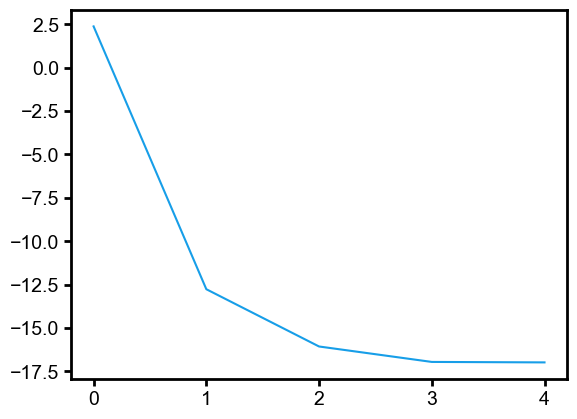

In [28]:
plt.plot([uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi])
print(uc_mi, psf_4_mi, rml_mi, diffuser_mi, phlat_mi)

### Repeat with different patch sizes and counts